In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, dopioe


In [2]:
def unit_det(Q, symmetrize=True):
    Q = np.asarray(Q, dtype=float)
    d = np.linalg.det(Q)
    if not np.isfinite(d) or d <= 0: raise ValueError("det(Q) must be positive and finite")
    s = 1/np.sqrt(d)
    return s*Q, s

def tangential_velocity(xp, yp, up, vp, xc, yc, Q, det1=False):
    Q = np.asarray(Q, float)
    if Q.shape == (3,):
        q11, q12, q22 = Q
        Q = np.array([[q11, q12], [q12, q22]], float)
    if det1:
        d = np.linalg.det(Q)
        if d != 0:
            Q /= np.sqrt(d)

    xp, yp, up, vp = (np.asarray(a, float) for a in (xp, yp, up, vp))
    r   = np.stack((xp - xc, yp - yc), axis=-1)
    g   = 2.0 * (r @ Q.T)                    # ∇F
    J   = np.array([[0., -1.], [1., 0.]])    # +90° rot
    tau = g @ J.T                             # tangent
    nrm = np.linalg.norm(tau, axis=-1, keepdims=True)
    t_hat = np.divide(tau, nrm, out=np.zeros_like(tau), where=nrm > 0)

    vel = np.stack((up, vp), axis=-1)
    vt  = np.sum(vel * t_hat, axis=-1)
    vt  = np.where(nrm.squeeze() > 0, vt, np.nan)
    return vt#, t_hat
    

In [3]:
x, y = np.linspace(-100, 100, 100), np.linspace(-100, 100, 100)
X, Y = np.meshgrid(x, y, indexing='ij')

xc, yc = 0, 0
Q11, Q12, Q22 = 1, 0.25, 1
psi0 = -100
Rc = 35
A = - psi0 / Rc**2

# rescale Q to have unit determinant
Q, _ = unit_det(Q=np.array([[Q11, Q12], [Q12, Q22]]))
q11, q12, q22 = Q[0,0], Q[0,1], Q[1,1]

df_res = pd.DataFrame({'xc': [xc], 'yc': [yc], 'q11': [q11], 'q12': [q12], 'q22': [q22],
                       'Rc': [Rc], 'psi0': [psi0], 'A': [A]})

dx, dy = X - xc, Y - yc
rho2 = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
Qr2 = (q11*dx + q12*dy)**2 + (q12*dx + q22*dy)**2 # ||Qr||
psi = psi0 * np.exp( - rho2 / Rc**2 )
u =   psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q12*dx + 2*q22*dy ) / Rc**2
v = - psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q11*dx + 2*q12*dy ) / Rc**2

# vt = (-2*psi0*np.sqrt(rho2)/Rc**2)*np.exp(-rho2/Rc**2)


In [4]:
# given: X, Y, xc, yc, Q (unit det), psi0, Rc

# 1) Build S with Q = S^T S
# Cholesky gives Q = L L^T; we want S = L^T so that Q = S^T S
L = np.linalg.cholesky(Q)         # Q = L @ L.T
S = L.T                           # so that Q = S.T @ S
S_inv = np.linalg.inv(S)

# 2) Coordinates and stacking
dx, dy = X - xc, Y - yc
r = np.stack([dx, dy], axis=0)    # shape (2, Ny, Nx)

# 3) Map to circular coordinates y = S r  (avoid matmul shape mismatch)
y = np.einsum('ij,jmn->imn', S, r)     # (2, Ny, Nx)
d = np.linalg.norm(y, axis=0)          # radius in y-space

# 4) Streamfunction and original velocities (your formula)
rho2 = np.einsum('imn,ij,jmn->mn', r, Q, r)             # r^T Q r
psi = psi0 * np.exp(-rho2 / Rc**2)
u =  psi * (2*(Q[0,1]*dx + Q[1,1]*dy)) / Rc**2
v = -psi * (2*(Q[0,0]*dx + Q[0,1]*dy)) / Rc**2
uvec = np.stack([u, v], axis=0)

# 5) Tangent direction corresponding to circles in y-space: t_x ∝ S^{-1} J y
J = np.array([[0, 1], [-1, 0]])
Jy = np.einsum('ij,jmn->imn', J, y)                  # J y
t = np.einsum('ij,jmn->imn', S_inv, Jy)              # S^{-1} J y  (2, Ny, Nx)
t_norm = np.linalg.norm(t, axis=0)
t_hat = t / (t_norm + 1e-15)

# 6) Tangential speed and the analytic profile
vt = np.einsum('imn,imn->mn', uvec, t_hat)           # u · t_hat
A = -psi0 / Rc**2
vt_analytic = 2 * A * d * np.exp(-d**2 / Rc**2)


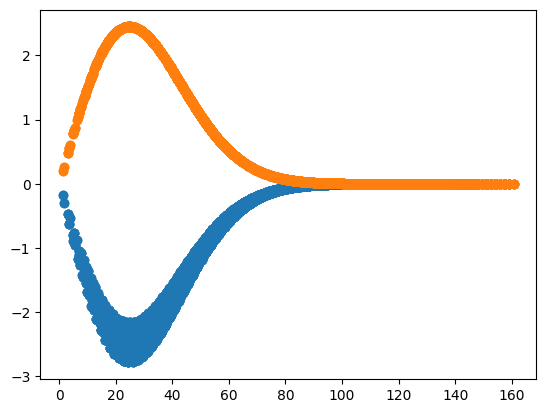

In [8]:
plt.scatter(d, vt)
plt.scatter(d, vt_analytic)


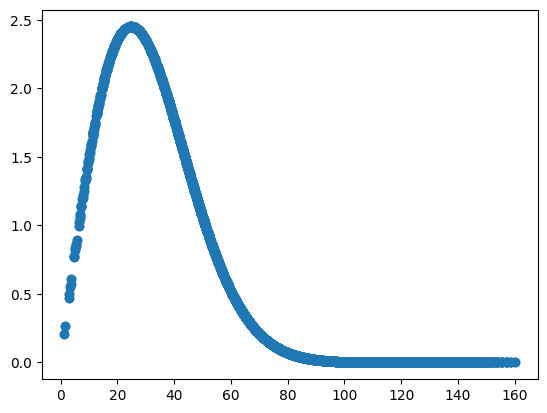

In [26]:
plt.scatter(d, vtp_analytic)

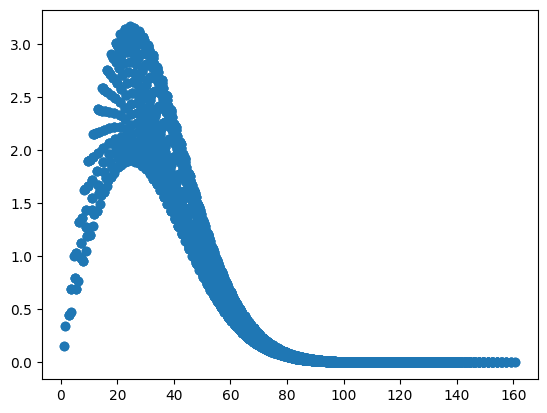

In [36]:
# Q is SPD. For Cholesky, np.linalg.cholesky(Q) returns Lc with Q = Lc @ Lc.T.
# We want Q = L^T L, so take L = Lc.T
Lc = np.linalg.cholesky(Q)
L = Lc.T
Linvt = np.linalg.inv(L).T
J = np.array([[0., -1.],
              [1.,  0.]])

dx, dy = X - xc, Y - yc
r = np.stack([dx, dy], axis=0)                     # (2, nx, ny)

# y = L r  and  u' = L^{-T} u  using einsum
y  = np.einsum('ij,jxy->ixy', L, r)                # (2, nx, ny)
d  = np.linalg.norm(y, axis=0)                     # (nx, ny)

u_field = np.stack([u, v], axis=0)                 # (2, nx, ny)
u_prime = np.einsum('ij,jxy->ixy', Linvt, u_field) # (2, nx, ny)
up, vp = u_prime[0], u_prime[1]

# t̂' = (J y)/||y||
tprime = np.einsum('ij,jxy->ixy', J, y)            # (2, nx, ny)
normy = np.linalg.norm(y, axis=0)
txp = np.zeros_like(up); typ = np.zeros_like(vp)
m = normy > 0
txp[m] = tprime[0,m]/normy[m]
typ[m] = tprime[1,m]/normy[m]

vt_prime = up*txp + vp*typ  
plt.scatter(d, vt_prime)


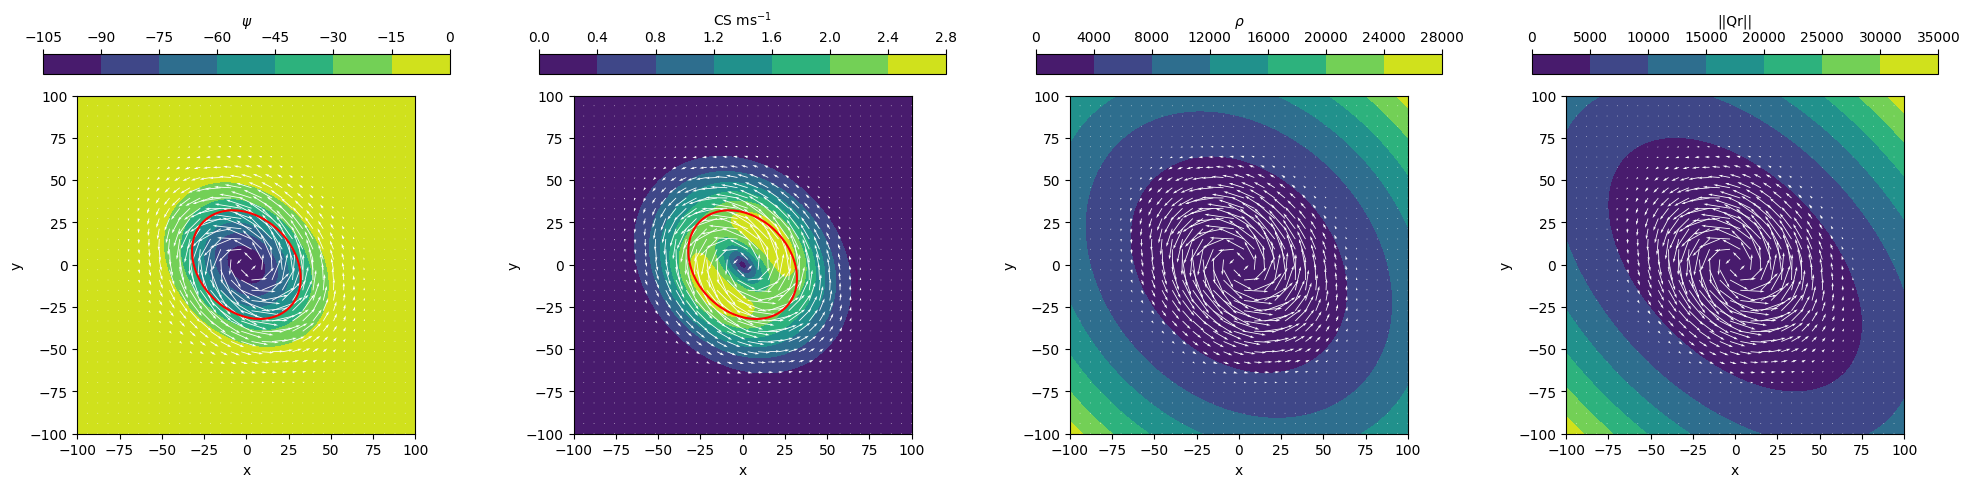

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))

# First subplot
c0 = axs[0].contourf(X, Y, psi)
fig.colorbar(c0, ax=axs[0], label=r'$\psi$',
             orientation='horizontal', location='top')
spac = 3
axs[0].quiver(X[::spac, ::spac], Y[::spac, ::spac],
              u[::spac, ::spac], v[::spac, ::spac], color='white')
axs[0].contour(X, Y, rho2, colors='r', levels=[1000], alpha=1)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')

# Second subplot
c1 = axs[1].contourf(X, Y, np.hypot(u, v))
fig.colorbar(c1, ax=axs[1], label=r'CS ms$^{-1}$',
             orientation='horizontal', location='top')
axs[1].quiver(X[::spac, ::spac], Y[::spac, ::spac],
              u[::spac, ::spac], v[::spac, ::spac], color='white')
axs[1].contour(X, Y, rho2, colors='r', levels=[1000], alpha=1)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_aspect('equal')

c2 = axs[2].contourf(X, Y, rho2)
fig.colorbar(c2, ax=axs[2], label=r'$\rho$',
             orientation='horizontal', location='top')
axs[2].quiver(X[::spac, ::spac], Y[::spac, ::spac],
              u[::spac, ::spac], v[::spac, ::spac], color='white')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_aspect('equal')

c3 = axs[3].contourf(X, Y, Qr2)
fig.colorbar(c3, ax=axs[3], label='||Qr||',
             orientation='horizontal', location='top')
axs[3].quiver(X[::spac, ::spac], Y[::spac, ::spac],
              u[::spac, ::spac], v[::spac, ::spac], color='white')
axs[3].set_xlabel('x')
axs[3].set_ylabel('y')
axs[3].set_aspect('equal')

plt.tight_layout()
plt.show()


In [12]:
x0, y0 = 0, 0
r = 25
# nearest indices to (x0, y0)
i0 = np.argmin(np.abs(x - x0))
j0 = np.argmin(np.abs(y - y0)) 
# zonal transect at y = y0
mask_x = np.abs(x - x0) < r
x1, y1 = x[mask_x], np.full(np.sum(mask_x), y[j0])
u1, v1 = u[mask_x, j0], v[mask_x, j0]
# meridional transect at x = x0
mask_y = np.abs(y - y0) < r
x2, y2 = np.full(np.sum(mask_y), x[i0]), y[mask_y]
u2, v2 = u[i0, mask_y], v[i0, mask_y]

points1 = set(zip(x1, y1)); points2 = set(zip(x2, y2))
common_points = points1 & points2
# Remove duplicates from (x1, y1, u1, v1)
mask = ~np.array([(x, y) in common_points for x, y in zip(x1, y1)])
x1f = x1[mask]; y1f = y1[mask]; u1f = u1[mask]; v1f = v1[mask]
# Concatenate with unaltered second set
xi = np.concatenate([x1f, x2]); yi = np.concatenate([y1f, y2])
ui = np.concatenate([u1f, u2]); vi = np.concatenate([v1f, v2])

xc_dop, yc_dop, w_dop, AQ_dop, *_ = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
A_dop = np.sqrt(np.linalg.det(AQ_dop)) # det(Q) = 1, A = -psi0/Rc**2
q11_dop, q12_dop, q22_dop = AQ_dop[0,0]/A_dop, AQ_dop[1,0]/A_dop, AQ_dop[1,1]/A_dop
Q_dop = np.array([[q11_dop, q12_dop], [q12_dop, q22_dop]])

dx_dop, dy_dop = xi - xc_dop, yi - yc_dop
rho2_dop = q11_dop*dx_dop**2 + 2*q12_dop*dx_dop*dy_dop + q22_dop*dy_dop**2
rho_dop = np.sqrt(rho2_dop)
Qr_dop = np.sqrt((q11_dop*dx_dop + q12_dop*dy_dop)**2
                  + (q12_dop*dx_dop + q22_dop*dy_dop)**2) #||Qr||
vt_dop = np.abs(tangential_velocity(xi, yi, ui, vi, xc_dop, yc_dop, Q_dop))
idx_max_vt = np.where(vt_dop==np.max(vt_dop))[0][0]
Qr_dop_max = Qr_dop[idx_max_vt]
Rc_dop = Qr_dop_max * np.sqrt(2) # Rc = rho_max * np.sqrt(2)
psi0_dop = - A_dop * Rc_dop**2 

df_res.loc[len(df_res)] = {'xc': xc_dop, 'yc': yc_dop, 'q11': q11_dop, 'q12': q12_dop, 'q22': q22_dop,
                           'Rc': Rc_dop, 'psi0': psi0_dop, 'A': A_dop}
df_res


,xc,yc,q11,q12,q22,Rc,psi0,A
0,0.000000,0.000000,1.032796,0.258199,1.032796,35.000000,-100.000000,0.081633
1,-0.003471,-0.003471,1.032776,0.258119,1.032776,35.708845,-101.586694,0.079668
2,-0.003471,-0.003471,1.032776,0.258119,1.032776,35.708845,-101.586694,0.079668


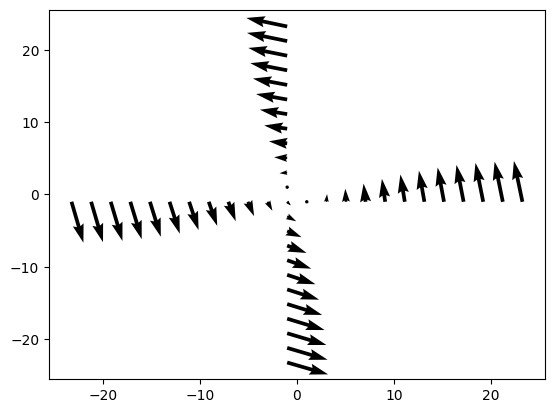

In [6]:
plt.quiver(x1, y1, u1, v1)
plt.quiver(x2, y2, u2, v2)


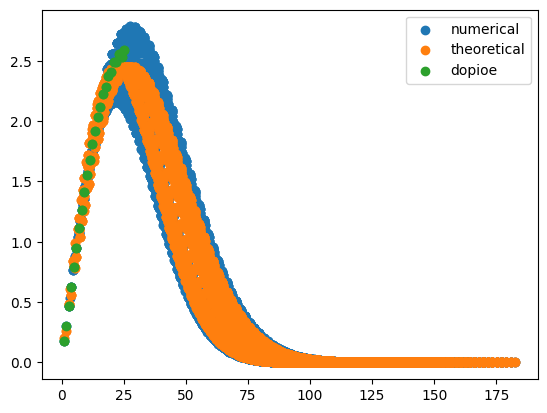

In [10]:
points1 = set(zip(x1, y1)); points2 = set(zip(x2, y2))
common_points = points1 & points2
# Remove duplicates from (x1, y1, u1, v1)
mask = ~np.array([(x, y) in common_points for x, y in zip(x1, y1)])
x1f = x1[mask]; y1f = y1[mask]; u1f = u1[mask]; v1f = v1[mask]
# Concatenate with unaltered second set
xi = np.concatenate([x1f, x2]); yi = np.concatenate([y1f, y2])
ui = np.concatenate([u1f, u2]); vi = np.concatenate([v1f, v2])

vt_numerical = tangential_velocity(X.flatten(), Y.flatten(), u.flatten(), v.flatten(), xc, yc, Q)
plt.scatter(np.sqrt(Qr2), np.abs(vt_numerical), label='numerical') # Why does this not match the theoretical????

plt.scatter(np.sqrt(Qr2), np.abs(vt), label='theoretical')

plt.scatter(Qr_dop, np.abs(vt_dop), label='dopioe')

plt.legend()


### ROMS data

In [8]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
import pickle
df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_eddies_processed_1462_10650.pkl')


In [ ]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')
fnumber_old = 0


In [ ]:
df_eddies[df_eddies.Eddy==971]


In [ ]:
eddy = 971
day = 4550

r = 150
data = df_eddies[(df_eddies.Eddy==eddy)&(df_eddies['Day']==day)].iloc[0]
fname = data.fname
fnumber = fname[-8:-3]
if fnumber != fnumber_old:

    u_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/u_' + fnumber + '.npy')
    v_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/v_' + fnumber + '.npy')
    
    u_raw = np.where(np.abs(u_raw) > 1e30, np.nan, u_raw).astype(float)
    v_raw = np.where(np.abs(v_raw) > 1e30, np.nan, v_raw).astype(float)
    
    with nc.Dataset(fname) as dataset:
        ocean_time = dataset.variables['ocean_time'][:].data / 86400
    fnumber_old = fnumber
t_rel = np.where(ocean_time == day)[0][0]

u_t, v_t = u_raw[:, :, :, t_rel], v_raw[:, :, :, t_rel]

xc_surf, yc_surf = data.xc, data.yc
ic = np.where(np.abs(x_grid-xc_surf)==np.min(np.abs(x_grid-xc_surf)))[0][0]
jc = np.where(np.abs(y_grid-yc_surf)==np.min(np.abs(y_grid-yc_surf)))[0][0]

x_mask = np.where(np.abs(x_grid - xc_surf) < r)[0]
y_mask = np.where(np.abs(y_grid - yc_surf) < r)[0]
X_mask, Y_mask = np.meshgrid(x_mask, y_mask)


In [ ]:
k = 0
plt.contourf(X_grid[X_mask, Y_mask], Y_grid[X_mask, Y_mask], np.hypot(u_t[X_mask, Y_mask,k], v_t[X_mask, Y_mask,k]))
spac = 5
plt.quiver(X_grid[X_mask[::spac, ::spac], Y_mask[::spac, ::spac]], Y_grid[X_mask[::spac, ::spac], Y_mask[::spac, ::spac]],
           u_t[X_mask[::spac, ::spac], Y_mask[::spac, ::spac],k], v_t[X_mask[::spac, ::spac], Y_mask[::spac, ::spac],k])
plt.scatter(data.xc, data.yc, marker='x', color='r')
plt.axis('equal')


In [ ]:
X_local, Y_local = X_grid[X_mask, Y_mask], Y_grid[X_mask, Y_mask]
x_local, y_local = X_local[0,:], Y_local[:,0]
u_local, v_local = u_t[X_mask, Y_mask,k].T, v_t[X_mask, Y_mask,k].T


In [ ]:
x0, y0 = xc_surf, yc_surf
r = 40

i0 = np.argmin(np.abs(x_local - x0))
j0 = np.argmin(np.abs(y_local - y0))

mask_x = np.abs(x_local - x0) < r
x1 = x_local[mask_x]
y1 = np.full(mask_x.sum(), y_local[j0])
u1 = u_local[mask_x, j0]
v1 = v_local[mask_x, j0]

mask_y = np.abs(y_local - y0) < r
x2 = np.full(mask_y.sum(), x_local[i0])
y2 = y_local[mask_y]
u2 = u_local[i0, mask_y]
v2 = v_local[i0, mask_y]


In [ ]:
plt.quiver(x1, y1, u1, v1)
plt.quiver(x2, y2, u2, v2)


In [ ]:
points1 = set(zip(x1, y1)); points2 = set(zip(x2, y2))
common_points = points1 & points2
# Remove duplicates from (x1, y1, u1, v1)
mask = ~np.array([(x, y) in common_points for x, y in zip(x1, y1)])
x1f = x1[mask]; y1f = y1[mask]; u1f = u1[mask]; v1f = v1[mask]
# Concatenate with unaltered second set
xi = np.concatenate([x1f, x2]); yi = np.concatenate([y1f, y2])
ui = np.concatenate([u1f, u2]); vi = np.concatenate([v1f, v2])

xc_dop, yc_dop, w_dop, AQ_dop, *_ = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
A_dop = np.sqrt(np.linalg.det(AQ_dop)) # det(Q) = 1, A = -psi0/Rc**2
q11_dop, q12_dop, q22_dop = AQ_dop[0,0]/A_dop, AQ_dop[1,0]/A_dop, AQ_dop[1,1]/A_dop
Q_dop = np.array([[q11_dop, q12_dop], [q12_dop, q22_dop]])

dx_dop, dy_dop = xi - xc_dop, yi - yc_dop
rho2_dop = q11_dop*dx_dop**2 + 2*q12_dop*dx_dop*dy_dop + q22_dop*dy_dop**2
# rho_dop = np.sqrt(rho2_dop)
rho_dop = np.sqrt((q11_dop*dx_dop + q12_dop*dy_dop)**2
                  + (q12_dop*dx_dop + q22_dop*dy_dop)**2) #||Qr||
vt_dop = np.abs(tangential_velocity(xi, yi, ui, vi, xc_dop, yc_dop, Q_dop))
idx_max_vt = np.where(vt_dop==np.max(vt_dop))[0][0]
rho_dop_max = rho_dop[idx_max_vt]
Rc_dop = rho_dop_max * np.sqrt(2) # Rc = rho_max * np.sqrt(2)
psi0_dop = - A_dop * Rc_dop**2 

df_res = pd.DataFrame({'xc': [xc_dop], 'yc': [yc_dop], 'q11': [q11_dop], 'q12': [q12_dop], 'q22': [q22_dop],
                            'Rc': [Rc_dop], 'psi0': [psi0_dop], 'A': [A_dop]})
df_res


In [ ]:
data = df_res.iloc[0]

dx, dy = X_local - data.xc, Y_local - data.yc
rho2 = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
# rho2 = (data.q11*dx + data.q12*dy)**2 + (data.q12*dx + data.q22*dy)**2 # ||Qr||

psi = data.psi0 * np.exp( - rho2 / data.Rc**2 )
u_dop =   data.psi0 * np.exp( - rho2 / data.Rc**2 ) * ( 2*data.q12*dx + 2*data.q22*dy ) / data.Rc**2
v_dop = - data.psi0 * np.exp( - rho2 / data.Rc**2 ) * ( 2*data.q11*dx + 2*data.q12*dy ) / data.Rc**2


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))

c0 = axs[0].contourf(X_local, Y_local, np.hypot(u_local, v_local).T)
spac = 2
axs[0].quiver(X_local[::spac, ::spac], Y_local[::spac, ::spac],
              u_local[::spac, ::spac].T, v_local[::spac, ::spac].T, scale=10, color='w')
axs[0].plot(x1, y1, color='r'); axs[0].plot(x2, y2, color='r')
x_ell, y_ell = plot_ellipse(np.array([[data.q11, data.q12], [data.q12, data.q22]]),
                            center=(data.xc, data.yc), scale=data.Rc)
axs[0].plot(x_ell, y_ell, color='r')
axs[0].axis('equal')

c1 = axs[1].contourf(X_local, Y_local, np.hypot(u_dop, v_dop).T)
spac = 2
axs[1].quiver(X_local[::spac, ::spac], Y_local[::spac, ::spac],
              u_dop[::spac, ::spac], v_dop[::spac, ::spac], scale=10, color='w')
axs[1].scatter(data.xc, data.yc, marker='x', color='r')
axs[1].plot(x_ell, y_ell, color='r')
axs[1].axis('equal')

fig.colorbar(c1, ax=axs, orientation='vertical', label=r'$|u,v|$')
plt.show()


